In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [21]:

# BGM Model with Optimizations
class BGM:
    def __init__(self, times, ns_params, volatilities, num_paths=1000, num_steps=100):
        """
        Initialize the BGM model with stochastic forward rate dynamics.
        
        Parameters:
        - times: Array of maturities (e.g., from STRIPS data).
        - ns_params: Initial Nelson-Siegel parameters [beta0, beta1, beta2, tau].
        - volatilities: Array of volatilities for each forward rate.
        - num_paths: Number of Monte Carlo paths for simulation.
        - num_steps: Number of time steps for simulation.
        """
        self.times = np.array(times)
        self.ns_params = ns_params
        self.volatilities = np.array(volatilities)
        self.deltas = np.diff(times)
        self.N = len(times) - 1
        self.num_paths = num_paths
        self.num_steps = num_steps
        self.forwards = self.compute_ns_forwards()
        self.max_time = self.times[-1]  # Maximum maturity for simulation
        self.zero_cache = {}  # Cache for zero-coupon bond prices
        self.forward_paths = None  # Store precomputed forward rate paths
        self.simulate_forward_paths()  # Precompute forward rate paths

    def compute_ns_forwards(self):
        """
        Compute initial forward rates using the Nelson-Siegel model.
        """
        beta0, beta1, beta2, tau = self.ns_params
        forwards = []
        for i in range(self.N):
            t = self.times[i]
            f = beta0 + beta1 * np.exp(-t/tau) + beta2 * (t/tau) * np.exp(-t/tau)
            forwards.append(max(f, 0.0001))
        return np.array(forwards)

    def simulate_forward_paths(self):
        """
        Precompute forward rate paths up to the maximum maturity.
        """
        dt = self.max_time / self.num_steps
        sqrt_dt = np.sqrt(dt)

        # Initialize forward rate paths (num_paths x num_steps+1 x num_forwards)
        self.forward_paths = np.zeros((self.num_paths, self.num_steps + 1, self.N))
        self.forward_paths[:, 0, :] = self.forwards  # Set initial forward rates

        # Simulate forward rates using lognormal dynamics
        for t in range(self.num_steps):
            dW = np.random.normal(0, sqrt_dt, (self.num_paths, self.N))
            self.forward_paths[:, t + 1, :] = self.forward_paths[:, t, :] * np.exp(
                -0.5 * self.volatilities**2 * dt + self.volatilities * dW
            )

    def zero(self, t0, T):
        """
        Compute the price of a zero-coupon bond maturing at time T using precomputed forward rate paths.
        
        Parameters:
        - t0: Starting time (assumed to be 0).
        - T: Maturity time.
        
        Returns:
        - Price of the zero-coupon bond.
        """
        # Check if the result is already cached
        if T in self.zero_cache:
            return self.zero_cache[T]

        if T <= self.times[0]:
            price = 1.0
            self.zero_cache[T] = price
            return price

        # Compute discount factors using precomputed forward rate paths
        dt = self.max_time / self.num_steps
        num_steps_T = min(int(T / dt), self.num_steps)  # Number of steps up to T
        discounts = np.ones(self.num_paths)

        # Integrate the forward rates over time for each path
        for t in range(num_steps_T):
            current_time = t * dt
            forward_idx = np.searchsorted(self.times, current_time, side='left') - 1
            if forward_idx < 0:
                forward_idx = 0
            if forward_idx >= self.N:
                forward_idx = self.N - 1

            forward_rate = self.forward_paths[:, t, forward_idx]
            discounts *= np.exp(-forward_rate * dt)

        # Adjust for the remaining time fraction
        if num_steps_T * dt < T:
            remaining_time = T - num_steps_T * dt
            forward_idx = np.searchsorted(self.times, num_steps_T * dt, side='left') - 1
            if forward_idx < 0:
                forward_idx = 0
            if forward_idx >= self.N:
                forward_idx = self.N - 1
            forward_rate = self.forward_paths[:, num_steps_T, forward_idx]
            discounts *= np.exp(-forward_rate * remaining_time)

        # Compute the bond price as the average discount factor
        price = np.mean(discounts)
        price = max(price, 1e-10)
        self.zero_cache[T] = price  # Cache the result
        return price

    def update_params(self, ns_params):
        """
        Update the Nelson-Siegel parameters, recompute initial forward rates, and resimulate paths.
        """
        self.ns_params = ns_params
        self.forwards = self.compute_ns_forwards()
        self.zero_cache = {}  # Clear the cache
        self.simulate_forward_paths()  # Resimulate forward rate paths


In [22]:

# Optimized Function to Compute Bond Prices
def compute_bond_prices_with_coupons(model, maturities, face_value=100, coupon_rate=0.0, frequency=2):
    """
    Compute bond prices with coupons using vectorized operations where possible.
    
    Parameters:
    - model: BGM model instance.
    - maturities: Array of bond maturities.
    - face_value: Face value of the bonds.
    - coupon_rate: Annual coupon rate.
    - frequency: Coupon payment frequency per year.
    
    Returns:
    - Array of bond prices.
    """
    prices = np.zeros(len(maturities))
    
    # Compute principal prices for all maturities
    principal_prices = np.array([model.zero(0, tau) for tau in maturities]) * face_value
    prices += principal_prices

    # Handle coupon payments if coupon_rate > 0
    if coupon_rate > 0:
        coupon_payment = (coupon_rate / frequency) * face_value
        for i, tau in enumerate(maturities):
            if tau >= 1 / frequency:
                num_coupons = int(tau * frequency)
                coupon_times = np.linspace(1 / frequency, tau, num_coupons)
                # Vectorized computation of discount factors for coupon times
                discounts = np.array([model.zero(0, t) for t in coupon_times])
                coupon_price = np.sum(discounts * coupon_payment)
                prices[i] += coupon_price

    return prices


In [23]:

# Objective Function for Calibration
def objective_function(ns_params, model, maturities, market_prices, face_value):
    model.update_params(ns_params)
    model_prices = compute_bond_prices_with_coupons(model, maturities, face_value, 0.0, 2)
    return np.sum((model_prices - market_prices) ** 2)


In [24]:

# Load STRIPS Data 
df_strips = pd.read_csv('/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv')
latest_date = "2025-02-04"
latest_data = df_strips[df_strips['Date'] == latest_date].iloc[0]

maturities = []
strips_prices = []
for i in range(46):
    maturity_label = df_strips.columns[1 + i*3].split('_')[1]
    time_col = f'Time_{maturity_label}'
    price_col = f'Price_{maturity_label}'
    maturities.append(latest_data[time_col])
    strips_prices.append(latest_data[price_col])

maturities = np.array(maturities)
strips_prices = np.array(strips_prices)
face_value = 100

print("STRIPS Maturities:", maturities[:5])
print("STRIPS Prices:", strips_prices[:5])


STRIPS Maturities: [0.03011636 0.27378508 0.52566735 0.77754962 1.0294319 ]
STRIPS Prices: [99.932 98.863 97.544 96.805 95.935]


In [25]:
# Initialize BGM model with reduced Monte Carlo parameters for calibration
initial_ns_params = [0.04, -0.02, 0.01, 1.0]
volatilities = np.full(len(np.diff(maturities)), 0.2)
bgm = BGM(maturities, initial_ns_params, volatilities, num_paths=100, num_steps=50)  # Reduced for calibration

# Calibrate the model
result = minimize(
    objective_function,
    initial_ns_params,
    args=(bgm, maturities, strips_prices, face_value),
    method='Nelder-Mead',
    bounds=[(0, 0.1), (-0.1, 0.1), (-0.1, 0.1), (0.1, 5.0)]
)

calibrated_ns_params = result.x

# Reinitialize BGM model with higher Monte Carlo parameters for final pricing
bgm = BGM(maturities, calibrated_ns_params, volatilities, num_paths=1000, num_steps=100)
print("Calibrated Nelson-Siegel Parameters:", calibrated_ns_params)


Calibrated Nelson-Siegel Parameters: [ 0.04637782 -0.01841608  0.00981917  0.94665666]


In [26]:
# Load Bond data 
csv_file_path = "/Users/dr/Documents/GitHub/FixedIncome/bond data for pricing analysis.csv"
bond_df = pd.read_csv(csv_file_path)
bond_data = bond_df[['Security', 'Maturity', 'Coupon Rate', 'Price', 'Coupon Frequency']].copy()
bond_data['Coupon Rate'] = bond_data['Coupon Rate'] / 100
print("Bond Data:")
print(bond_data)


Bond Data:
              Security  Maturity  Coupon Rate       Price  Coupon Frequency
0          3-mo T-bill      0.25      0.00000   95.810000                 1
1   10yr Treasury Bond      9.88      0.04625  104.750000                 2
2    5yr Treasury Bond      4.99      0.04000  101.167969                 2
3    2yr Treasury Bond      2.66      0.00625   92.320312                 2
4             2yr TIPS      3.54      0.02375  104.843750                 2
5    Corporate Bond(A)      7.12      0.05125  101.677000                 2
6    Corporate Bond(B)      4.66      0.08875   62.076000                 2
7  Corporate Bond(BBB)     10.00      0.05500  100.433000                 2


In [27]:
# Compute Prices with Calibrated Model
zero_coupon_prices = compute_bond_prices_with_coupons(bgm, maturities, face_value, 0.0, 2)

# Bond prices
bond_model_prices = {}
for _, row in bond_data.iterrows():
    security = row['Security']
    coupon_rate = row['Coupon Rate']
    frequency = row['Coupon Frequency']
    bond_model_prices[security] = compute_bond_prices_with_coupons(bgm, maturities, face_value, coupon_rate, frequency)


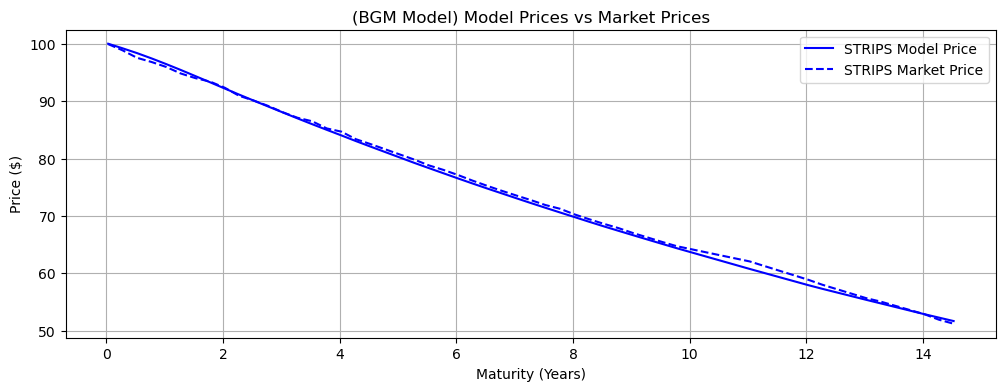

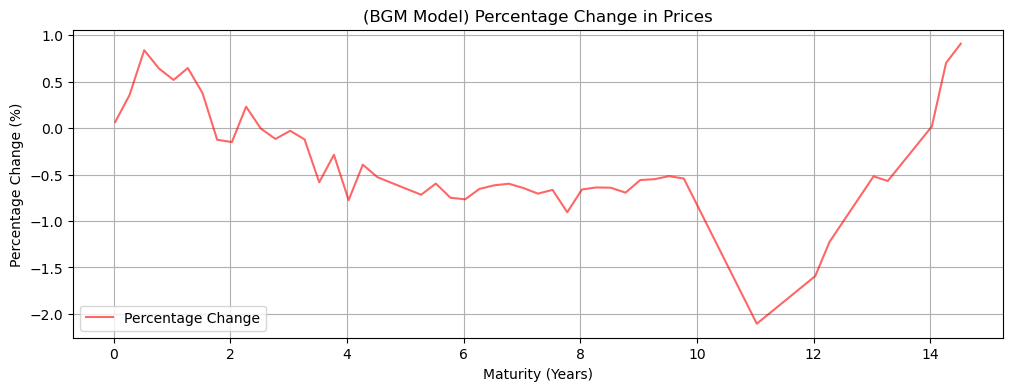

In [30]:
# Calculate percentage change in prices
percentage_change = ((zero_coupon_prices - strips_prices) / strips_prices) * 100

# Sort the data by maturity (times) to ensure smooth plotting
sorted_indices = np.argsort(maturities)
sorted_times = maturities[sorted_indices]
sorted_zero_coupon_prices = zero_coupon_prices[sorted_indices]
sorted_strips_prices = strips_prices[sorted_indices]
sorted_percentage_change = percentage_change[sorted_indices]

# Plot original graph (Model Prices vs Market Prices)
plt.figure(figsize=(12, 4))
plt.plot(sorted_times, sorted_zero_coupon_prices, 'b-', label='STRIPS Model Price', linewidth=1.5)
plt.plot(sorted_times, sorted_strips_prices, 'b--', label='STRIPS Market Price', linewidth=1.5)
plt.xlabel('Maturity (Years)')
plt.ylabel('Price ($)')
plt.title('(BGM Model) Model Prices vs Market Prices')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot percentage change graph
plt.figure(figsize=(12, 4))
# Using scatter plot for percentage change to avoid "scratched" appearance
plt.plot(sorted_times, sorted_percentage_change, color='red', linestyle='-', label='Percentage Change', alpha=0.6)
plt.xlabel('Maturity (Years)')
plt.ylabel('Percentage Change (%)')
plt.title('(BGM Model) Percentage Change in Prices')
plt.legend()
plt.grid(True)
plt.show()



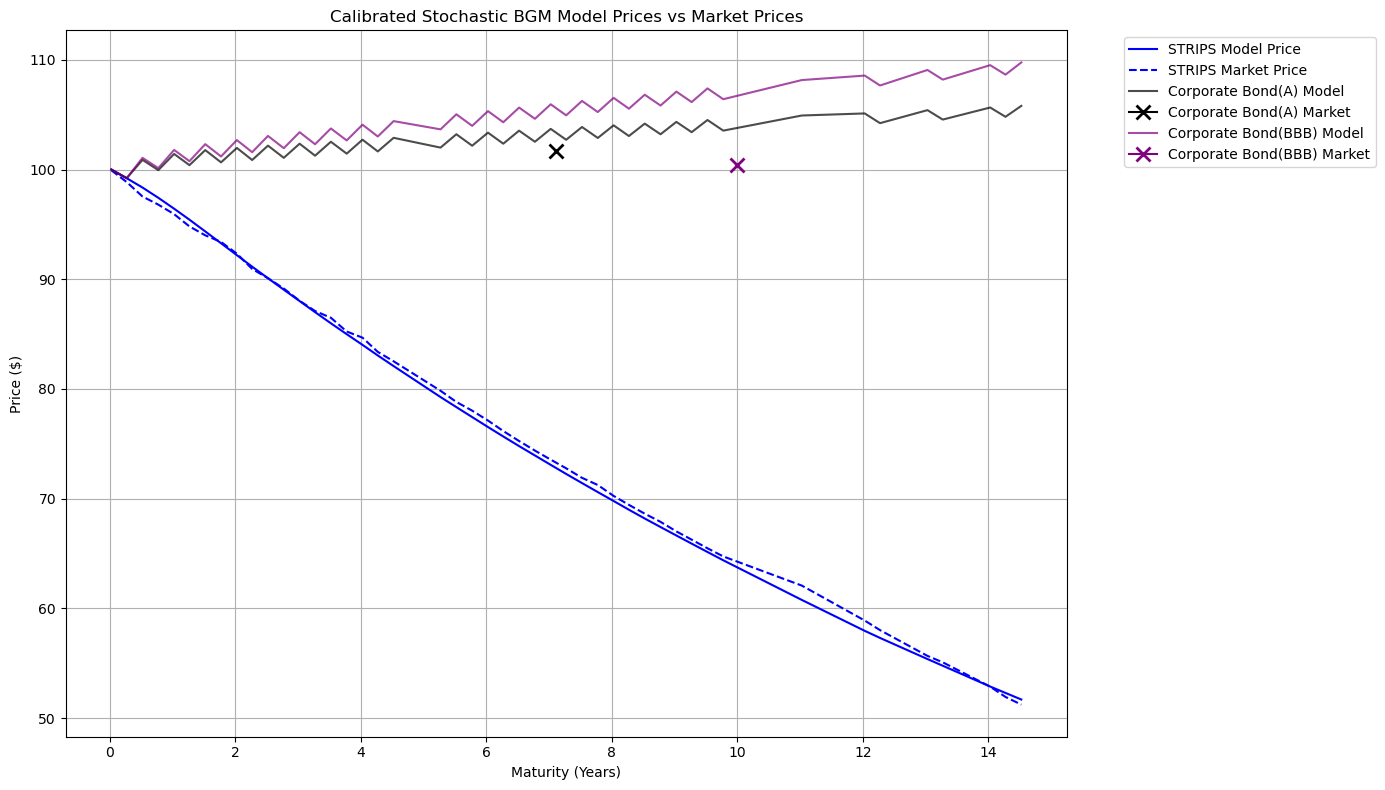

In [35]:
# Plotting 
plt.figure(figsize=(14, 8))

# STRIPS
plt.plot(maturities, zero_coupon_prices, 'b-', label='STRIPS Model Price', linewidth=1.5)
plt.plot(maturities, strips_prices, 'b--', label='STRIPS Market Price', linewidth=1.5)

# Bonds
colors = ['r', 'g', 'c', 'm', 'y', 'k', 'orange', 'purple']
for i, (security, prices) in enumerate(bond_model_prices.items()):
    if i == 5 or i == 7:  # Plot only Corporate Bonds A, B, and BBB
        plt.plot(maturities, prices, color=colors[i], linestyle='-', label=f'{security} Model', alpha=0.7)
        maturity = bond_data.loc[bond_data['Security'] == security, 'Maturity'].values[0]
        market_price = bond_data.loc[bond_data['Security'] == security, 'Price'].values[0]
        plt.plot(maturity, market_price, marker='x', color=colors[i], markersize=10, markeredgewidth=2, label=f'{security} Market')

plt.xlabel('Maturity (Years)')
plt.ylabel('Price ($)')
plt.title('Calibrated Stochastic BGM Model Prices vs Market Prices')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

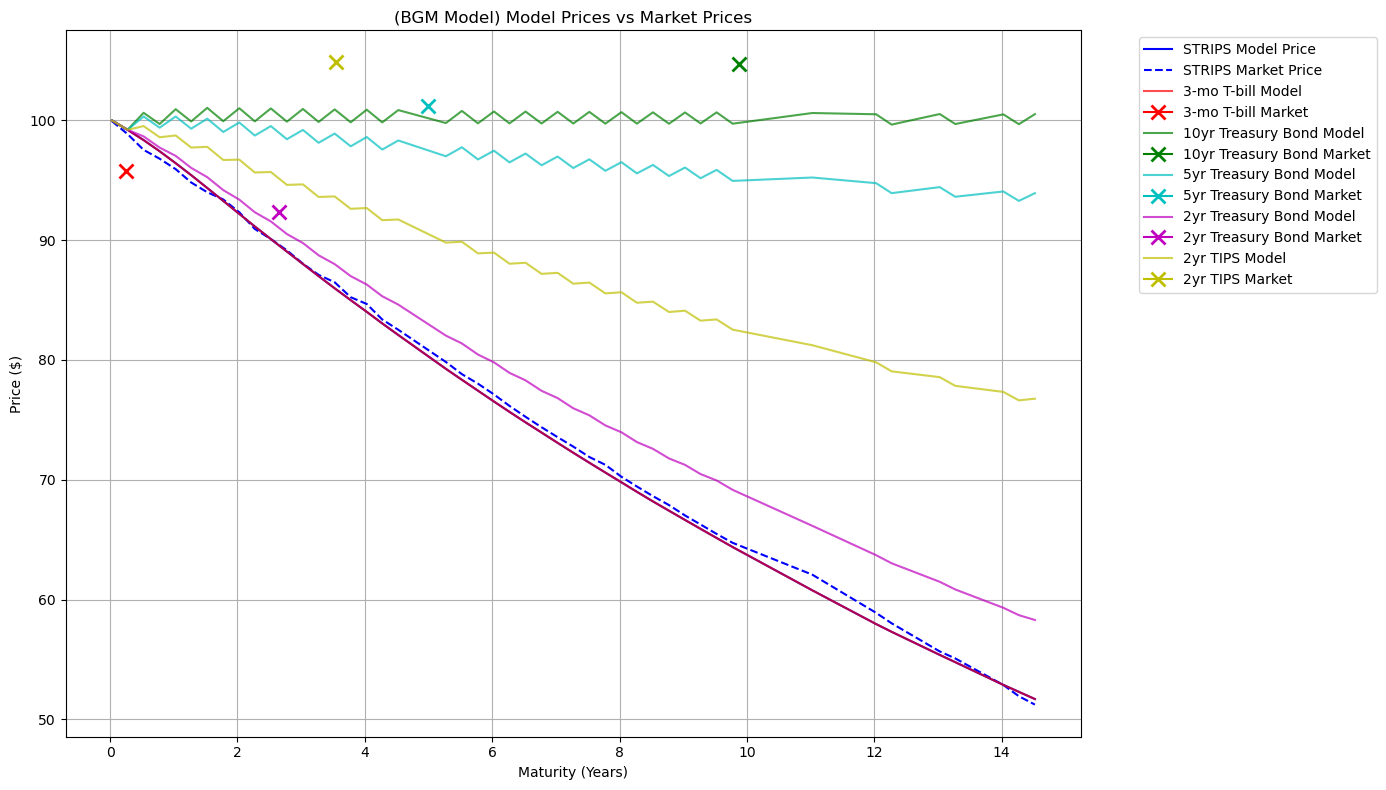

In [39]:
# Plotting 
plt.figure(figsize=(14, 8))

# STRIPS
plt.plot(maturities, zero_coupon_prices, 'b-', label='STRIPS Model Price', linewidth=1.5)
plt.plot(maturities, strips_prices, 'b--', label='STRIPS Market Price', linewidth=1.5)

# Bonds
colors = ['r', 'g', 'c', 'm', 'y', 'k', 'orange', 'purple']
for i, (security, prices) in enumerate(bond_model_prices.items()):
    if i < 5:  # Plot only bonds with index less than 5
        plt.plot(maturities, prices, color=colors[i], linestyle='-', label=f'{security} Model', alpha=0.7)
        maturity = bond_data.loc[bond_data['Security'] == security, 'Maturity'].values[0]
        market_price = bond_data.loc[bond_data['Security'] == security, 'Price'].values[0]
        plt.plot(maturity, market_price, marker='x', color=colors[i], markersize=10, markeredgewidth=2, label=f'{security} Market')

plt.xlabel('Maturity (Years)')
plt.ylabel('Price ($)')
plt.title('(BGM Model) Model Prices vs Market Prices')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()